<a href="https://colab.research.google.com/github/vivekd16/Deep-Learning/blob/main/02_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#neural network classification

In [49]:
from sklearn.datasets import make_circles

n_samples=1000
X,y=make_circles(n_samples,noise=0.03,random_state=42)

In [50]:
len(X),len(y)

(1000, 1000)

In [51]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [52]:
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


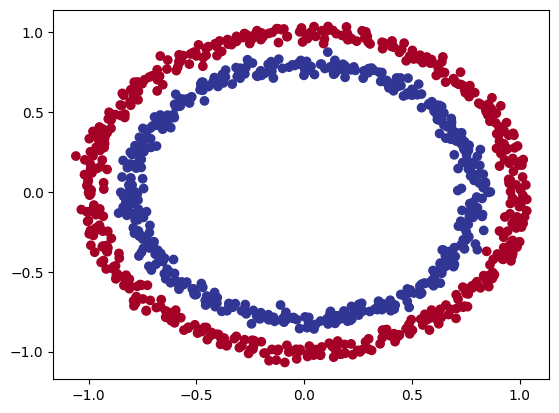

In [53]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,
            cmap=plt.cm.RdYlBu)

In [54]:
X.shape,y.shape

((1000, 2), (1000,))

In [55]:
X[0],y[0]

(array([0.75424625, 0.23148074]), 1)

In [56]:
import torch

In [57]:
type(X)

numpy.ndarray

In [58]:
X=torch.from_numpy(X).type(torch.float)

In [59]:
y=torch.from_numpy(y).type(torch.float)

In [60]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [63]:
len(X_train),len(X_test)

(800, 200)

In [64]:
import torch
from torch import nn
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [65]:
class circlemodelv0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layer_2=nn.Linear(in_features=5,out_features=1)
  def forward(self,x):
    return self.layer_2(self.layer_1(x))
model_0=circlemodelv0().to(device)
model_0

circlemodelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [66]:
model_0=nn.Sequential(nn.Linear(in_features=2,out_features=5,bias=True),nn.Linear(in_features=5,out_features=1,bias=True)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [67]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5142,  0.3776],
                      [-0.4782,  0.4100],
                      [ 0.2150, -0.0767],
                      [ 0.6036, -0.1219],
                      [-0.5031, -0.5492]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0352, -0.1670,  0.1406, -0.2194, -0.6517], device='cuda:0')),
             ('1.weight',
              tensor([[0.3508, 0.0977, 0.2027, 0.3810, 0.1880]], device='cuda:0')),
             ('1.bias', tensor([0.1053], device='cuda:0'))])

In [68]:
with torch.inference_mode():
  untrained_preds=model_0(X_test.to(device))
[len(untrained_preds),untrained_preds.shape,len(X_test),X_test.shape,untrained_preds[:10],y_test[:10]]

[200,
 torch.Size([200, 1]),
 200,
 torch.Size([200, 2]),
 tensor([[-0.1885],
         [-0.0644],
         [-0.2982],
         [-0.1583],
         [ 0.0442],
         [ 0.1173],
         [ 0.1954],
         [ 0.2388],
         [-0.3125],
         [-0.0523]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])]

In [69]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [70]:
def accuracy_fn(y_true,y_preds):
  correct=torch.eq(y_true,y_preds).sum().item()
  acc=(correct/len(y_preds))*100
  return acc

In [71]:
device

'cuda'

In [72]:
!nvidia-smi

Sun Feb 23 14:28:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             35W /   70W |     158MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [73]:
#training loop

In [74]:
torch.cuda.manual_seed=42
epochs=1000
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()
  y_logits=model_0(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_preds=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_preds=test_preds)
  if epoch%10==0:
    print(f"epoch:{epoch} | loss:{loss:.5f},acc:{acc:.2f}| test_loss:{test_loss:.5f},test_acc:{test_acc:.2f}")

epoch:0 | loss:0.69813,acc:48.75| test_loss:0.70193,test_acc:49.50
epoch:10 | loss:0.69675,acc:49.00| test_loss:0.70033,test_acc:49.50
epoch:20 | loss:0.69581,acc:49.62| test_loss:0.69915,test_acc:50.00
epoch:30 | loss:0.69513,acc:49.75| test_loss:0.69824,test_acc:49.50
epoch:40 | loss:0.69463,acc:49.50| test_loss:0.69753,test_acc:49.50
epoch:50 | loss:0.69425,acc:49.75| test_loss:0.69696,test_acc:48.50
epoch:60 | loss:0.69396,acc:50.25| test_loss:0.69651,test_acc:49.50
epoch:70 | loss:0.69375,acc:50.12| test_loss:0.69614,test_acc:49.50
epoch:80 | loss:0.69358,acc:49.75| test_loss:0.69585,test_acc:49.00
epoch:90 | loss:0.69345,acc:49.50| test_loss:0.69561,test_acc:49.50
epoch:100 | loss:0.69335,acc:49.50| test_loss:0.69542,test_acc:49.50
epoch:110 | loss:0.69327,acc:49.50| test_loss:0.69526,test_acc:49.00
epoch:120 | loss:0.69321,acc:50.00| test_loss:0.69513,test_acc:48.50
epoch:130 | loss:0.69316,acc:50.25| test_loss:0.69503,test_acc:49.50
epoch:140 | loss:0.69312,acc:50.12| test_loss

In [75]:
from urllib import request
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("downloading helper_functions.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
  from helper_functions import plot_predictions,plot_decision_boundary

helper_functions.py already exists


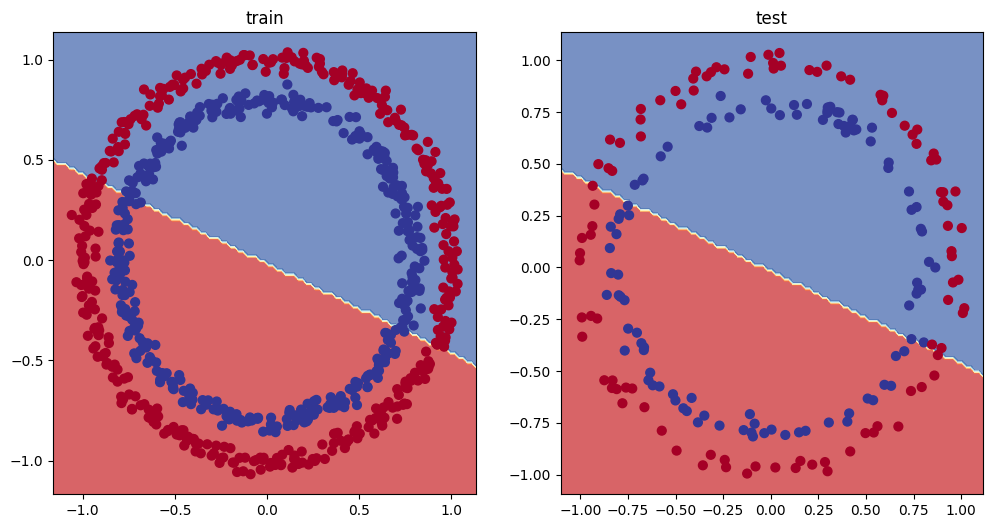

In [77]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0,X_test,y_test)